In [1]:
import time
import numpy as np
import scipy.special
import jax.numpy as jnp
import matplotlib.pyplot as plt
# import optimizer_traj_opt

from jax import jit, jacfwd, jacrev, random, vmap
from jax.config import config
config.update("jax_enable_x64", True)

#### Bernstein Coefficient Polynomials

In [2]:
def bernstein_coeff_order10_new(n, tmin, tmax, t_actual):
    l = tmax - tmin
    t = (t_actual - tmin) / l

    P0 = scipy.special.binom(n, 0) * ((1 - t) ** (n - 0)) * t ** 0
    P1 = scipy.special.binom(n, 1) * ((1 - t) ** (n - 1)) * t ** 1
    P2 = scipy.special.binom(n, 2) * ((1 - t) ** (n - 2)) * t ** 2
    P3 = scipy.special.binom(n, 3) * ((1 - t) ** (n - 3)) * t ** 3
    P4 = scipy.special.binom(n, 4) * ((1 - t) ** (n - 4)) * t ** 4
    P5 = scipy.special.binom(n, 5) * ((1 - t) ** (n - 5)) * t ** 5
    P6 = scipy.special.binom(n, 6) * ((1 - t) ** (n - 6)) * t ** 6
    P7 = scipy.special.binom(n, 7) * ((1 - t) ** (n - 7)) * t ** 7
    P8 = scipy.special.binom(n, 8) * ((1 - t) ** (n - 8)) * t ** 8
    P9 = scipy.special.binom(n, 9) * ((1 - t) ** (n - 9)) * t ** 9
    P10 = scipy.special.binom(n, 10) * ((1 - t) ** (n - 10)) * t ** 10

    P0dot = -10.0 * (-t + 1) ** 9
    P1dot = -90.0 * t * (-t + 1) ** 8 + 10.0 * (-t + 1) ** 9
    P2dot = -360.0 * t ** 2 * (-t + 1) ** 7 + 90.0 * t * (-t + 1) ** 8
    P3dot = -840.0 * t ** 3 * (-t + 1) ** 6 + 360.0 * t ** 2 * (-t + 1) ** 7
    P4dot = -1260.0 * t ** 4 * (-t + 1) ** 5 + 840.0 * t ** 3 * (-t + 1) ** 6
    P5dot = -1260.0 * t ** 5 * (-t + 1) ** 4 + 1260.0 * t ** 4 * (-t + 1) ** 5
    P6dot = -840.0 * t ** 6 * (-t + 1) ** 3 + 1260.0 * t ** 5 * (-t + 1) ** 4
    P7dot = -360.0 * t ** 7 * (-t + 1) ** 2 + 840.0 * t ** 6 * (-t + 1) ** 3
    P8dot = 45.0 * t ** 8 * (2 * t - 2) + 360.0 * t ** 7 * (-t + 1) ** 2
    P9dot = -10.0 * t ** 9 + 9 * t ** 8 * (-10.0 * t + 10.0)
    P10dot = 10.0 * t ** 9

    P0ddot = 90.0 * (-t + 1) ** 8
    P1ddot = 720.0 * t * (-t + 1) ** 7 - 180.0 * (-t + 1) ** 8
    P2ddot = 2520.0 * t ** 2 * (-t + 1) ** 6 - 1440.0 * t * (-t + 1) ** 7 + 90.0 * (-t + 1) ** 8
    P3ddot = 5040.0 * t ** 3 * (-t + 1) ** 5 - 5040.0 * t ** 2 * (-t + 1) ** 6 + 720.0 * t * (-t + 1) ** 7
    P4ddot = 6300.0 * t ** 4 * (-t + 1) ** 4 - 10080.0 * t ** 3 * (-t + 1) ** 5 + 2520.0 * t ** 2 * (-t + 1) ** 6
    P5ddot = 5040.0 * t ** 5 * (-t + 1) ** 3 - 12600.0 * t ** 4 * (-t + 1) ** 4 + 5040.0 * t ** 3 * (-t + 1) ** 5
    P6ddot = 2520.0 * t ** 6 * (-t + 1) ** 2 - 10080.0 * t ** 5 * (-t + 1) ** 3 + 6300.0 * t ** 4 * (-t + 1) ** 4
    P7ddot = -360.0 * t ** 7 * (2 * t - 2) - 5040.0 * t ** 6 * (-t + 1) ** 2 + 5040.0 * t ** 5 * (-t + 1) ** 3
    P8ddot = 90.0 * t ** 8 + 720.0 * t ** 7 * (2 * t - 2) + 2520.0 * t ** 6 * (-t + 1) ** 2
    P9ddot = -180.0 * t ** 8 + 72 * t ** 7 * (-10.0 * t + 10.0)
    P10ddot = 90.0 * t ** 8

    P = np.hstack((P0, P1, P2, P3, P4, P5, P6, P7, P8, P9, P10))
    Pdot = np.hstack((P0dot, P1dot, P2dot, P3dot, P4dot, P5dot, P6dot, P7dot, P8dot, P9dot, P10dot)) / l
    Pddot = np.hstack((P0ddot, P1ddot, P2ddot, P3ddot, P4ddot, P5ddot, P6ddot, P7ddot, P8ddot, P9ddot, P10ddot)) / (l ** 2)
    return P, Pdot, Pddot

#### Initializations

In [3]:
x_min = -6.0
x_max = 6.0

y_min = -6.0
y_max = 6.0

t_fin = 8.0
num = 20

In [4]:
tot_time = np.linspace(0.0, t_fin, num)
tot_time_copy = tot_time.reshape(num, 1)
P, Pdot, Pddot = bernstein_coeff_order10_new(10, tot_time_copy[0], tot_time_copy[-1], tot_time_copy)
nvar = np.shape(P)[1]
num = np.shape(P)[0]

In [5]:
x_obs_temp = np.hstack((0, 1, 2.0, 2.5))
y_obs_temp = np.hstack((1.0, 0, -1.0, -1.5))
num_obs = np.shape(x_obs_temp)[0]

a_obs = 1.0
b_obs = 1.0

x_obs = np.ones((num_obs, num)) * x_obs_temp[:, np.newaxis]
y_obs = np.ones((num_obs, num)) * y_obs_temp[:, np.newaxis]

In [6]:
x_init = -2.87
y_init = 2.96
vx_init = 0.0
ax_init = 0.0
vy_init = 0.0
ay_init = 0.0

In [7]:
x_fin = 3
y_fin = -2
vx_fin = 0.0
ax_fin = 0.0
vy_fin = 0.0
ay_fin = 0.0

In [8]:
rho_obs = 0.3
rho_eq = 10.0
weight_smoothness = 10

In [9]:
bx_eq =  np.hstack((x_init, vx_init, ax_init, x_fin, vx_fin, ax_fin))
by_eq =  np.hstack((y_init, vy_init, ay_init, y_fin, vy_fin, ay_fin))

In [10]:
A_eq = np.vstack((P[0], Pdot[0], Pddot[0], P[-1], Pdot[-1], Pddot[-1]))
A_obs = np.tile(P, (num_obs, 1))
Q_smoothness = np.dot(Pddot.T, Pddot)

In [11]:
P_jax = jnp.asarray(P)
A_eq_jax = jnp.asarray(A_eq)
A_obs_jax = jnp.asarray(A_obs)
x_obs_jax = jnp.asarray(x_obs)
y_obs_jax = jnp.asarray(y_obs)
Q_smoothness_jax = jnp.asarray(Q_smoothness)

#### Compute Solution

In [12]:
def compute_sol(rho_obs, rho_eq, weight_smoothness, num_obs, bx_eq, by_eq, P, Pdot, Pddot, x_obs, y_obs, a_obs, b_obs):    
    maxiter = 300
    nvar = np.shape(P)[1]
    num = np.shape(P)[0]

    A_eq = np.vstack((P[0], Pdot[0], Pddot[0], P[-1], Pdot[-1], Pddot[-1]))
    A_obs = np.tile(P, (num_obs, 1))

    cost_smoothness = weight_smoothness * np.dot(Pddot.T, Pddot)

    alpha_obs = np.zeros((num_obs, num))
    d_obs = np.ones((num_obs, num))

    lamda_x = np.zeros(nvar)
    lamda_y = np.zeros(nvar)
    res_obs = np.ones(maxiter)
    res_eq = np.ones(maxiter)
    res_obs = np.ones(maxiter)
    res_eq = np.ones(maxiter)
    d_min = np.ones(maxiter)
    cost = cost_smoothness + rho_obs * np.dot(A_obs.T, A_obs) + rho_eq * np.dot(A_eq.T, A_eq)
    
    for i in range(0, maxiter):
        temp_x_obs = d_obs * np.cos(alpha_obs) * a_obs
        #print("temp_x_obs.shape: {}".format(temp_x_obs.shape, x_obs.shape))
        b_obs_x = x_obs.reshape(num * num_obs) + temp_x_obs.reshape(num * num_obs)
        #print("x_obs.shape: {}, b_obs_x.shape: {}".format(x_obs.shape, b_obs_x.shape))

        temp_y_obs = d_obs * np.sin(alpha_obs) * b_obs
        b_obs_y = y_obs.reshape(num * num_obs) + temp_y_obs.reshape(num*num_obs)

        lincost_x = -lamda_x - rho_obs * np.dot(A_obs.T, b_obs_x) - rho_eq * np.dot(A_eq.T, bx_eq)
        lincost_y = -lamda_y - rho_obs * np.dot(A_obs.T, b_obs_y) - rho_eq * np.dot(A_eq.T, by_eq)

        sol_x = np.linalg.solve(-cost, lincost_x)
        sol_y = np.linalg.solve(-cost, lincost_y)
        
        #print("sol_x.shape: {}, sol_y.shape: {}".format(sol_x.shape, sol_y.shape))

        x = np.dot(P, sol_x)
        y = np.dot(P, sol_y)
        
        #print("x.shape: {}, y.shape: {}".format(x.shape, y.shape))

        wc_alpha = (x - x_obs)
        ws_alpha = (y - y_obs)
        #print("wc_alpha.shape: {}, ws_alpha.shape: {}".format(wc_alpha.shape, ws_alpha.shape))
        alpha_obs = np.arctan2(ws_alpha * a_obs, wc_alpha * b_obs)
        
        c1_d = 1.0 * rho_obs * (a_obs ** 2 * np.cos(alpha_obs) ** 2 + b_obs ** 2 * np.sin(alpha_obs) ** 2)
        c2_d = 1.0 * rho_obs * (a_obs * wc_alpha * np.cos(alpha_obs) + b_obs * ws_alpha * np.sin(alpha_obs))

        d_temp = c2_d / c1_d
        d_obs = np.maximum(np.ones((num_obs, num)), d_temp)
        d_min[i] = np.amin(d_temp)

        res_x_obs_vec = wc_alpha - a_obs * d_obs * np.cos(alpha_obs)
        res_y_obs_vec = ws_alpha - b_obs * d_obs * np.sin(alpha_obs)
        
        res_eq_x_vec = np.dot(A_eq, sol_x) - bx_eq
        res_eq_y_vec = np.dot(A_eq, sol_y) - by_eq

        lamda_x = lamda_x-rho_obs*np.dot(A_obs.T, res_x_obs_vec.reshape(num_obs * num)) - rho_eq * np.dot(A_eq.T, res_eq_x_vec)
        lamda_y = lamda_y-rho_obs*np.dot(A_obs.T, res_y_obs_vec.reshape(num_obs * num)) - rho_eq * np.dot(A_eq.T, res_eq_y_vec)

        res_eq[i] = np.linalg.norm(np.hstack((res_eq_x_vec,  res_eq_y_vec)))
        res_obs[i] = np.linalg.norm(np.hstack((res_x_obs_vec, res_y_obs_vec)))

    slack_obs = np.sqrt((d_obs - 1))
    plt.figure(1)
    plt.plot(res_obs)
    plt.figure(2)
    plt.plot(res_eq)
    plt.show()
    return x, y, sol_x, sol_y, alpha_obs.reshape(num_obs*num), d_obs.reshape(num_obs*num), lamda_x, lamda_y, slack_obs.reshape(num_obs*num)

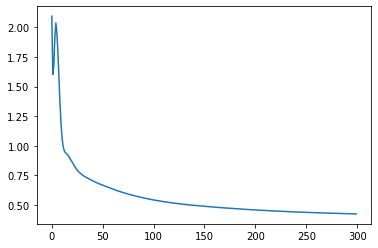

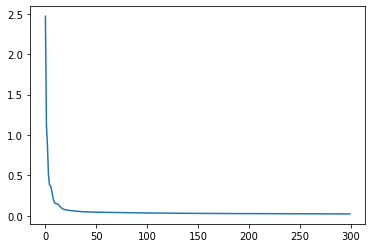

In [13]:
x, y, sol_x, sol_y, alpha_obs, d_obs, lamda_x, lamda_y, slack_obs = compute_sol(rho_obs, rho_eq, weight_smoothness, num_obs, bx_eq, by_eq, P, Pdot, Pddot, x_obs, y_obs, a_obs, b_obs)
lamda_x_jax = jnp.asarray(lamda_x)
lamda_y_jax = jnp.asarray(lamda_y)

#### Cost function

In [ ]:
# x^T -> (1 x n)
# Q -> (n x n)
# x -> (n x 1)

# x^T Q x -> 1 x 1

# x^T -> (B x n)
# Q -> (n x n)
# x -> (n x B)

# x^T Q x -> B x B 

# 1. 
# for i in range(B):
#     x^T -> (1 x n)
#     Q -> (n x n)
#     x -> (n x 1)
#     lst.append(output)

# 2.
# diag(x^T Q x) -> B x B -> [B x 1]

# 1 and 2 are same

In [17]:
def cost_fun(aug_sol_jax, param_sol):
    x_init, vx_init, ax_init, x_fin, vx_fin, ax_fin, y_init, vy_init, ay_init, y_fin, vy_fin, ay_fin = param_sol

    bx_eq_jax =  jnp.hstack((x_init, vx_init, ax_init, x_fin, vx_fin, ax_fin))
    by_eq_jax =  jnp.hstack((y_init, vy_init, ay_init, y_fin, vy_fin, ay_fin))

    c_x = aug_sol_jax[0:nvar]
    c_y = aug_sol_jax[nvar:2*nvar]

    num_tot = num_obs * num

    alpha_obs = aug_sol_jax[2*nvar:2*nvar+num_tot]
    d_obs = aug_sol_jax[2*nvar+num_tot:2*nvar+2*num_tot]

    cost_smoothness_x = 0.5 * weight_smoothness * jnp.dot(c_x.T, jnp.dot(Q_smoothness_jax, c_x))
    cost_smoothness_y = 0.5 * weight_smoothness * jnp.dot(c_y.T, jnp.dot(Q_smoothness_jax, c_y))

    temp_x_obs = d_obs * jnp.cos(alpha_obs) * a_obs
    b_obs_x = x_obs_jax.reshape(num * num_obs) + temp_x_obs

    temp_y_obs = d_obs * jnp.sin(alpha_obs) * b_obs
    b_obs_y = y_obs_jax.reshape(num * num_obs) + temp_y_obs

    cost_obs_x = 0.5 * rho_obs * (jnp.sum((jnp.dot(A_obs_jax, c_x) - b_obs_x) ** 2))
    cost_obs_y = 0.5 * rho_obs * (jnp.sum((jnp.dot(A_obs_jax, c_y) - b_obs_y) ** 2))
    
    cost_slack = rho_obs * jnp.sum(jnp.maximum(jnp.zeros(num_tot), -d_obs + 1))
    cost_eq_x = 0.5 * rho_eq * (jnp.sum((jnp.dot(A_eq_jax, c_x) - bx_eq_jax) ** 2))
    cost_eq_y = 0.5 * rho_eq * (jnp.sum((jnp.dot(A_eq_jax, c_y) - by_eq_jax) ** 2))
    
    cost_x = cost_smoothness_x + cost_obs_x + cost_eq_x - jnp.dot(lamda_x_jax.T, c_x)
    cost_y = cost_smoothness_y + cost_obs_y + cost_eq_y - jnp.dot(lamda_y_jax.T, c_y)
   
    eps = 10 ** (-8.0)
    cost = cost_x + cost_y + eps * jnp.sum(c_x ** 2) + eps * jnp.sum(c_y ** 2) + eps * jnp.sum(d_obs ** 2) + eps * jnp.sum(alpha_obs ** 2) + cost_slack
    return cost

#### Compute argmin derivative

In [18]:
hess_inp = jit(jacfwd(jacrev(cost_fun)))
hess_param = jit(jacfwd(jacrev(cost_fun), argnums=1))

In [19]:
aug_sol = np.hstack(( sol_x, sol_y, alpha_obs, d_obs))
aug_sol_jax = jnp.asarray(aug_sol)

params = jnp.hstack((x_init, vx_init, ax_init, x_fin, vx_fin, ax_fin, y_init, vy_init, ay_init, y_fin, vy_fin, ay_fin))

F_yy = hess_inp(aug_sol, params)
F_xy = hess_param(aug_sol, params)
F_yy_inv = jnp.linalg.inv(F_yy)

dgx = jnp.dot(-F_yy_inv, F_xy)

In [20]:
aug_sol.shape, params.shape

((182,), (12,))

In [21]:
aug_sol = np.hstack(( sol_x, sol_y, alpha_obs, d_obs))
aug_sol_jax = jnp.asarray(aug_sol)

#### debug compute solution dimensions and values

In [12]:
alpha_obs = np.zeros((num_obs, num))
d_obs = np.ones((num_obs, num))

lamda_x = np.zeros(nvar)
lamda_y = np.zeros(nvar)

In [13]:
bx_eq = np.array([-1.6721, -0.0158,  0.2543, -0.5678,  0.0000,  0.0000])
by_eq = np.array([2.1997, -1.7899, -0.6161, -0.7362,  0.0000,  0.0000])
bx_eq, by_eq

(array([-1.6721, -0.0158,  0.2543, -0.5678,  0.    ,  0.    ]),
 array([ 2.1997, -1.7899, -0.6161, -0.7362,  0.    ,  0.    ]))

In [14]:
maxiter = 300
cost_smoothness = weight_smoothness * np.dot(Pddot.T, Pddot)
cost = cost_smoothness + rho_obs * np.dot(A_obs.T, A_obs) + rho_eq * np.dot(A_eq.T, A_eq)

In [15]:
for i in range(0, maxiter):
    temp_x_obs = d_obs * np.cos(alpha_obs) * a_obs
    b_obs_x = x_obs.reshape(num * num_obs) + temp_x_obs.reshape(num * num_obs)

    temp_y_obs = d_obs * np.sin(alpha_obs) * b_obs
    b_obs_y = y_obs.reshape(num * num_obs) + temp_y_obs.reshape(num*num_obs)

    lincost_x = -lamda_x - rho_obs * np.dot(A_obs.T, b_obs_x) - rho_eq * np.dot(A_eq.T, bx_eq)
    lincost_y = -lamda_y - rho_obs * np.dot(A_obs.T, b_obs_y) - rho_eq * np.dot(A_eq.T, by_eq)

    sol_x = np.linalg.solve(-cost, lincost_x)
    sol_y = np.linalg.solve(-cost, lincost_y)

    #print("sol_x.shape: {}, sol_y.shape: {}".format(sol_x.shape, sol_y.shape))

    x = np.dot(P, sol_x)
    y = np.dot(P, sol_y)

    #print("x.shape: {}, y.shape: {}".format(x.shape, y.shape))

    wc_alpha = (x - x_obs)
    ws_alpha = (y - y_obs)
    #print("wc_alpha.shape: {}, ws_alpha.shape: {}".format(wc_alpha.shape, ws_alpha.shape))
    alpha_obs = np.arctan2(ws_alpha * a_obs, wc_alpha * b_obs)

    c1_d = 1.0 * rho_obs * (a_obs ** 2 * np.cos(alpha_obs) ** 2 + b_obs ** 2 * np.sin(alpha_obs) ** 2)
    c2_d = 1.0 * rho_obs * (a_obs * wc_alpha * np.cos(alpha_obs) + b_obs * ws_alpha * np.sin(alpha_obs))

    d_temp = c2_d / c1_d
    d_obs = np.maximum(np.ones((num_obs, num)), d_temp)

    res_x_obs_vec = wc_alpha - a_obs * d_obs * np.cos(alpha_obs)
    res_y_obs_vec = ws_alpha - b_obs * d_obs * np.sin(alpha_obs)

    res_eq_x_vec = np.dot(A_eq, sol_x) - bx_eq
    res_eq_y_vec = np.dot(A_eq, sol_y) - by_eq
    
    lamda_x = lamda_x-rho_obs*np.dot(A_obs.T, res_x_obs_vec.reshape(num_obs * num)) - rho_eq * np.dot(A_eq.T, res_eq_x_vec)
    lamda_y = lamda_y-rho_obs*np.dot(A_obs.T, res_y_obs_vec.reshape(num_obs * num)) - rho_eq * np.dot(A_eq.T, res_eq_y_vec)

In [16]:
new_sol = np.hstack((sol_x, sol_y, alpha_obs.reshape(-1), d_obs.reshape(-1)))
new_sol.shape

(182,)

In [17]:
new_sol

array([-1.6751658 , -1.68951276, -1.52324114, -2.28990924, -0.02903121,
       -2.67892934,  0.03876907, -1.18994783, -0.56813012, -0.56799649,
       -0.56786717,  2.19920053,  0.76694869, -1.10346246,  0.77083299,
       -4.02462577,  0.97830399, -2.21887333, -0.95216784, -0.73627433,
       -0.73624414, -0.73621506,  1.49359387,  1.47614969,  1.45273147,
        1.41984932,  1.367335  ,  1.28642396,  1.17694747,  1.05269985,
        0.9366822 ,  0.84533192,  0.78056644,  0.73675863,  0.70926153,
        0.69634445,  0.69654173,  0.70571562,  0.71685165,  0.72335532,
        0.7238006 ,  0.72303366,  2.2066572 ,  2.67550559, -2.90869704,
       -2.43910483, -2.1933838 , -2.04608281, -1.94679206, -1.87525128,
       -1.82016904, -1.77356385, -1.72989868, -1.68639021, -1.64295589,
       -1.60111702, -1.56227602, -1.52663475, -1.49389958, -1.46580318,
       -1.44779524, -1.44354678,  2.57120368,  2.69387151,  2.81306498,
        2.91613655,  3.00297129,  3.075527  ,  3.13378807, -3.10

In [ ]:
new_sol[:15]

In [19]:
lamda_x

array([ 4.6492705 , -7.27762464,  2.45053826, -0.59394761, -0.07953847,
        0.03847494,  0.04978413,  0.03464998,  0.53340047,  2.4514911 ,
       -2.26056138])

In [21]:
x1 = np.dot(P, new_sol[:11])

In [22]:
y1 = np.dot(P, new_sol[11:22])

In [23]:
x1

array([-1.6751658 , -1.67303967, -1.66887841, -1.65507872, -1.61945231,
       -1.56104207, -1.48677433, -1.4043049 , -1.31777312, -1.2277359 ,
       -1.13370863, -1.0368879 , -0.94116697, -0.85187624, -0.7731814 ,
       -0.70614884, -0.64953617, -0.60378099, -0.57483995, -0.56786717])

In [ ]:
def cost_fun_new(aug_sol_jax, param_sol):
    x_init, vx_init, ax_init, x_fin, vx_fin, ax_fin, y_init, vy_init, ay_init, y_fin, vy_fin, ay_fin = param_sol

    bx_eq_jax =  jnp.hstack((x_init, vx_init, ax_init, x_fin, vx_fin, ax_fin))
    by_eq_jax =  jnp.hstack((y_init, vy_init, ay_init, y_fin, vy_fin, ay_fin))

    c_x = aug_sol_jax[0:nvar]
    c_y = aug_sol_jax[nvar:2*nvar]

    num_tot = num_obs * num

    alpha_obs = aug_sol_jax[2*nvar:2*nvar+num_tot]
    d_obs = aug_sol_jax[2*nvar+num_tot:2*nvar+2*num_tot]

    cost_smoothness_x = 0.5 * weight_smoothness * jnp.dot(c_x.T, jnp.dot(Q_smoothness_jax, c_x))
    cost_smoothness_y = 0.5 * weight_smoothness * jnp.dot(c_y.T, jnp.dot(Q_smoothness_jax, c_y))

    temp_x_obs = d_obs * jnp.cos(alpha_obs) * a_obs
    b_obs_x = x_obs_jax.reshape(num * num_obs) + temp_x_obs

    temp_y_obs = d_obs * jnp.sin(alpha_obs) * b_obs
    b_obs_y = y_obs_jax.reshape(num * num_obs) + temp_y_obs

    cost_obs_x = 0.5 * rho_obs * (jnp.sum((jnp.dot(A_obs_jax, c_x) - b_obs_x) ** 2))
    cost_obs_y = 0.5 * rho_obs * (jnp.sum((jnp.dot(A_obs_jax, c_y) - b_obs_y) ** 2))
    
    cost_slack = rho_obs * jnp.sum(jnp.maximum(jnp.zeros(num_tot), -d_obs + 1))
    cost_eq_x = 0.5 * rho_eq * (jnp.sum((jnp.dot(A_eq_jax, c_x) - bx_eq_jax) ** 2))
    cost_eq_y = 0.5 * rho_eq * (jnp.sum((jnp.dot(A_eq_jax, c_y) - by_eq_jax) ** 2))
    
    cost_x = cost_smoothness_x + cost_obs_x + cost_eq_x - jnp.dot(lamda_x.T, c_x)
    cost_y = cost_smoothness_y + cost_obs_y + cost_eq_y - jnp.dot(lamda_y.T, c_y)
   
    eps = 10 ** (-8.0)
    cost = cost_x + cost_y + eps * jnp.sum(c_x ** 2) + eps * jnp.sum(c_y ** 2) + eps * jnp.sum(d_obs ** 2) + eps * jnp.sum(alpha_obs ** 2) + cost_slack
    return cost

In [ ]:
cost_fun_new(new_sol, np.hstack((bx_eq, by_eq)))

In [ ]:
hess_inp = jit(jacfwd(jacrev(cost_fun_new)))
hess_param = jit(jacfwd(jacrev(cost_fun_new), argnums=1))

In [ ]:
aug_sol_jax = jnp.asarray(new_sol)
params = jnp.asarray(np.hstack((bx_eq, by_eq)))

F_yy = hess_inp(aug_sol_jax, params)
F_xy = hess_param(aug_sol_jax, params)
F_yy_inv = jnp.linalg.inv(F_yy)

In [ ]:
dgx = jnp.dot(-F_yy_inv, F_xy)

In [ ]:
dgx.shape

In [ ]:
np.save("dgx.npy", dgx)

In [ ]:
dgx